# Word Embedding and Semantic Change
**CSC2611 Lab** 

Kanika Chopra

In [65]:
import nltk
from nltk import bigrams
import numpy as np
from nltk.util import ngrams
from collections import Counter
from scipy.sparse import lil_matrix
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import math
import pandas as pd
import pickle

In [5]:
from gensim.models import KeyedVectors

## Synchronic Word Embedding

### Extract Embeddings

We want to first get the set W that we had from the earlier exercise.

**Get words from Brown Corpus**

In [6]:
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     /Users/kanikachopra/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [7]:
# Get all unigrams (words)
words = brown.words()

# Remove punctuation
words = [word.lower() for word in words if word.isalpha()]

# Get the Frequency Distribution
fdist = nltk.FreqDist(words)

# Extract top 5000 most common words
W = [pair[0].lower() for pair in fdist.most_common(5000)]

**Get words from Table 1 of RG65**

In [8]:
rg65 = pd.read_csv('rg65.csv')
table1 = np.array(rg65[['word1', 'word2']]).reshape(-1, 1)

# Remove duplicates
new_words = np.unique(table1).tolist()

**Combine data**

In [9]:
len(W), len(new_words)

(5000, 48)

In [10]:
missing_words = [word for word in new_words if word not in W]
W.extend(missing_words)
W = np.array(W)
W.shape

(5030,)

We have that |W| = 5031. Hence, there were 31 words that were not in the original corpus that were in Table 1. 

**Embeddings**

In [13]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
binary=True)

Let's get our embeddings first.

In [48]:
embeddings = []
for i in range(rg65.shape[0]):
    # Get word pair
    word1 = rg65.word1[i]
    word2 = rg65.word2[i]
    
    # Get embeddings for word pair
    emb1 = model[word1].reshape(1,-1)
    emb2 = model[word2].reshape(1,-1)
    
    # Store embeddings in a tuple
    embeddings.append((emb1, emb2))

### Cosine Distance & Pearson Correlation

Next, we want to calculate the cosine distance between each pair of word embeddings that we have extracted.

In [54]:
S_word2vec = []
for i in range(rg65.shape[0]):
    # Get embeddings 
    emb1 = embeddings[i][0]
    emb2 = embeddings[i][1]
    
    # Calculate cosine similarity
    cs = cosine_similarity(emb1, emb2)[0][0]
    S_word2vec.append(cs)

Using the cosine distance, we want to report on the Pearson correlation between word2vec-based and human similarities.

In [56]:
# Human similarity
S = rg65.similarity.values

In [ ]:
print(f"The pearson correlation coeffienct betweeen humans and the word2vec model is:\n{scipy.stats.pearsonr(S_w2v, S)[0]:.4f}")


In [60]:
# Pearson Correlation for human and word2vec
pearsonr(S, S_word2vec)

(0.7720616159417535, 5.0910636865267265e-14)

Below, we have our pearson correlations for the LSA and word-context vectors from the earlier exercise:

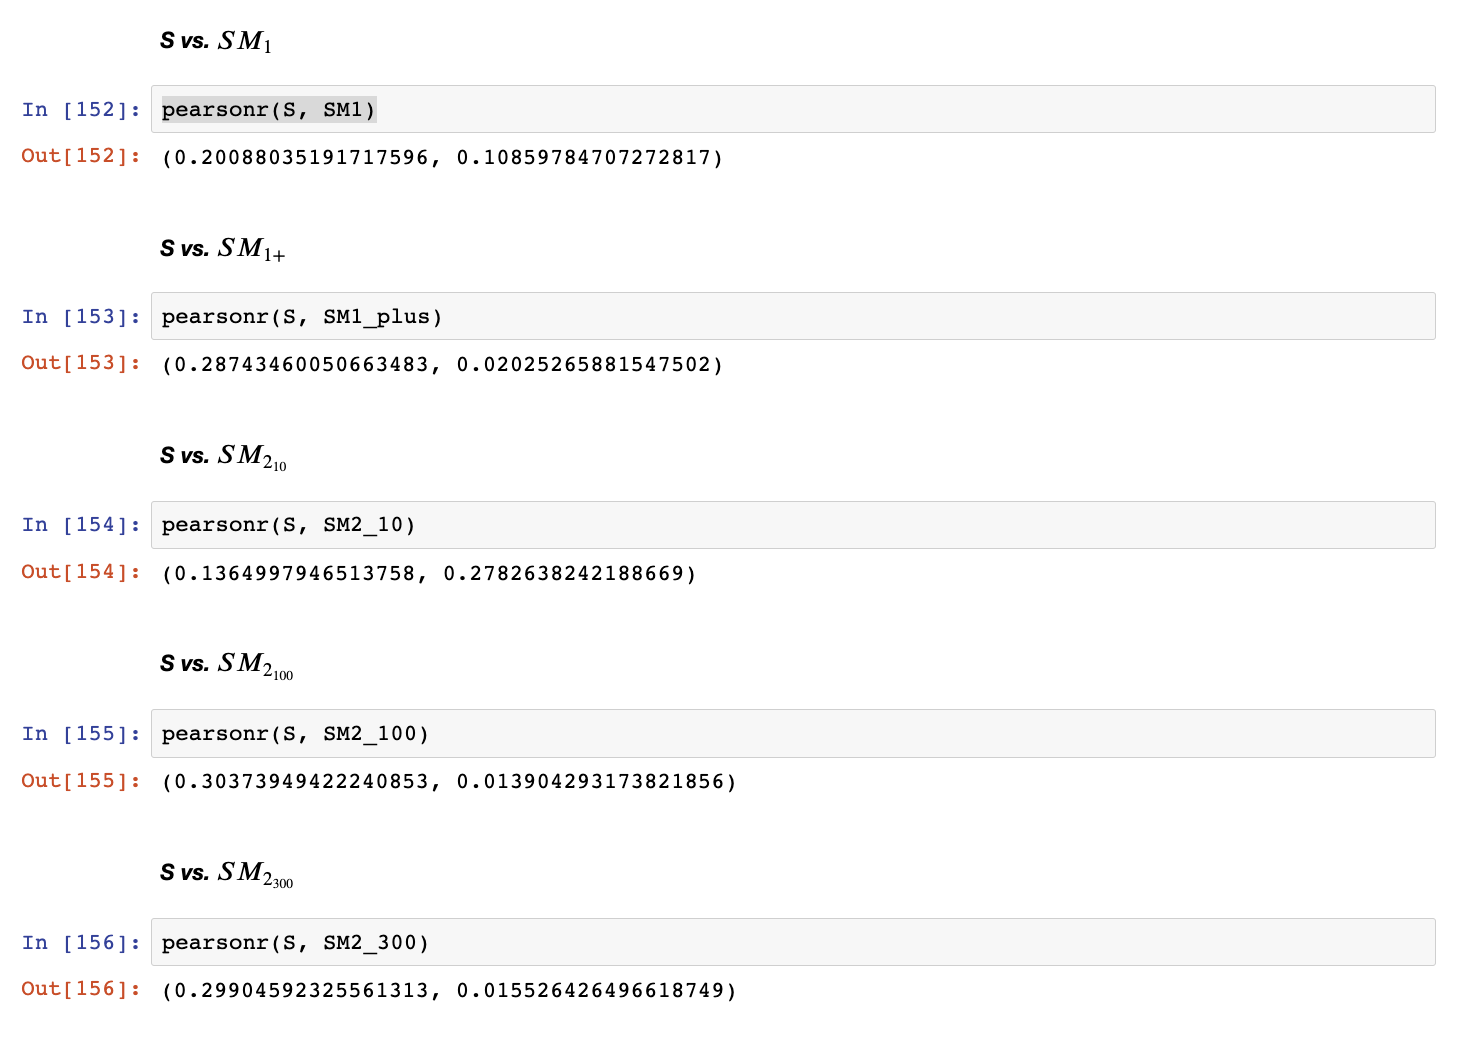

Hence, we can see that the Pearson correlation for word2vec and human similarities is much higher than the Pearson correlation for LSA from the exercise. With the size of the dataset, word2vec is better for measuring the degree of similarity with the embeddings than LSA. 

### Analogy Test

For the analogy test we want to report on the semantic and syntactic analogy. Hence, we begin by splitting our `word-test.v1.txt` file into two files for each of the tests. We split this dataset so that when the category begins with `gram` it is syntactic and the rest are semantic.

**Word2Vec Embeddings**

In [306]:
syntactic_analogy_word2vec = model.evaluate_word_analogies('syntactic.txt')
semantic_analogy_word2vec = model.evaluate_word_analogies('semantic.txt')

In [307]:
# Syntactic Analogy Word2Vec 
syntactic_analogy_word2vec[0]

0.7390163934426229

In [308]:
# Semantic Analogy Word2Vec
semantic_analogy_word2vec[0]

0.7415366839976892

**LSA Vectors**

We need to get our 300 dimensional LSA vector from the earlier exercise to apply this analysis.

In [76]:
# Get the bigrams
bwbg = bigrams(words)

# Get the Frequency Distribution
fdist_bwbg = nltk.FreqDist(bwbg)

M1 = np.zeros((len(W), len(W)))

# Iterate through words in W and count frequencies
for i, word1 in enumerate(W):
    for j, word2 in enumerate(W):
        M1[i,j] = fdist_bwbg[(word1, word2)]

In [77]:
# Calculate M1+
M1_plus_tmp = np.zeros((len(W), len(W)))

n = len(fdist_bwbg)
for i in range(len(W)):
    for j in range(len(W)):
        Pwc = M1[i,j]/n
        Pc = fdist.freq(W[i])
        Pw = fdist.freq(W[j])
        if (Pc != 0) & (Pw != 0) & (M1[i,j] != 0):
            M1_plus_tmp[i,j] = max(math.log(Pwc/(Pc*Pw),2),0)
        else:
            M1_plus_tmp[i,j] = 0 

In [78]:
M1_plus = lil_matrix(M1_plus_tmp)

# Apply PCA to get our 300-dimensional LSA vector
M2_300 = PCA(n_components=300).fit_transform(M1_plus_tmp)

Now, we want to train our model using M2_300 and our word set, W and then we will complete the analogy test similarly to the model trained from word2vec.

In [309]:
M2_300.shape

(5030, 300)

In [313]:
M2_300.shape[1]

300

In [318]:
lsa = KeyedVectors(300)

(5030,)

In [315]:
lsa.add(W, 

AttributeError: 'KeyedVectors' object has no attribute 'add'

I was not able to complete the analogy test for the LSA vectors; however, I assume that given the large corpora of text that word2vec has access to and its ability to generalize, that it would receive a higher score on the analogy test than the LSA vectors.

### Suggested Improvements

One way to improve the existing set of vector-based models in capturing word similarities in general would be to considering how frequently words are still used today. Analogies could be from contexts in the past which may have died out overtime in our regular day language which could make it more difficult to understand the relationship. On the other hand, the meanings of words could have changed as well which requires constantly updating these datasets for the analogies. One example could be for "awful" in which the meaning would have originally been "inspiring awe" and has now changed to "bad". If we were trying to get the opposite of "awful" using an analogy, the results would be different as the meaning of the word changes. Hence, updating the dataset to reflect the changed meanings in today's society would be important if we are trying to use the model on newer documents. 

Furthermore, understanding and investigating which words are polysemous would be important. This could be skewing the results as some words in the analogy may have multiple meaning so drawing the corresponding relationship could be difficult. From the syntactic data, a few examples are:
* Saying: This could be in terms of "They were saying.." or "The famous saying is..'
* Dance: This could be in terms of the action of dancing but could also mean the event such as a school's dance.

In these cases, the improvements lie within ensuring a good level of quality for the data and also understanding/investigating where mishaps could happen and considering these polysemous words. 

## Diachronic Word Embedding

We are working with the diachronic word2vec embeddings that capture historical usage of a small subset of English words over the past century.

In [72]:
with open('embeddings/data.pkl', 'rb') as f:
    data = pickle.load(f)

The format of this data is that for each word, there are 10 embeddings that represent each decade. The words are with the key `w`, the embeddings are in `e` and the decades are in `d`. 

### Proposed Methods
The three proposed methods for measuring the degree of semantic change for individual words are:
1. Cosine Similarity Between First and Last Decade of a Word
2. Average Cosine Similarity Between Consecutive Decades
3. Median Cosine Similarity Between Consecutive Decades

#### Method 1

In [91]:
num_words = len(data['w'])
num_decades = len(data['d'])

Now, we want to iterate through each of these words and calculate the cosine_similarity between each word in the first decade and the last decade.

In [119]:
method1 = []
for i in range(num_words):
    firstDecade = data['E'][i][0]
    lastDecade = data['E'][i][num_decades-1]
    
    cos_sim = cosine_similarity(np.reshape(firstDecade, (1,-1)), np.reshape(lastDecade, (1,-1)))[0][0]
    method1.append(cos_sim)

In [171]:
least20idx_method1 = np.argsort(method1)[:20]
top20idx_method1 = np.argsort(method1)[-20:]

In [178]:
# Top 20 changing words 
np.array(data['w'])[least20idx_method1]

array(['skills', 'techniques', 'ml', 'mcgraw', 'programs', 'objectives',
       'computer', 'radio', 'sector', 'goals', 'approach', 'van', 'shri',
       'media', 'impact', 'perspective', 'patterns', 'berkeley', 'shift',
       'film'], dtype='<U15')

In [179]:
# Least 20 changing words 
np.array(data['w'])[top20idx_method1]

array(['miles', 'payment', 'door', 'evening', 'week', 'feet', 'september',
       'god', 'december', 'daughter', 'months', 'century', 'january',
       'increase', 'october', 'years', 'february', 'november', 'june',
       'april'], dtype='<U15')

#### 2. Method 2 

In [202]:
method2 = []
for i in range(num_words):
    word_cs = []
  method2 = []
for i in range(num_words):
    word_cs = []
    for j in range(num_decades):
        firstDecade = data['E'][i][j]
        nextDecade = data['E'][i][j-1]
    
        cos_sim = cosine_similarity(np.reshape(firstDecade, (1,-1)), np.reshape(nextDecade, (1,-1)))[0][0]
        
        word_cs.append(cos_sim)
    method2.append(np.average(word_cs))

least20idx_method2 = np.argsort(method2)[:20]
top20idx_method2 = np.argsort(method2)[-20:]

# Top 20 changing words 
np.array(data['w'])[least20idx_method2]

# Least 20 changing words 
np.array(data['w'])[top20idx_method2]  for j in range(num_decades):
        firstDecade = data['E'][i][j]
        nextDecade = data['E'][i][j-1]
    
        cos_sim = cosine_similarity(np.reshape(firstDecade, (1,-1)), np.reshape(nextDecade, (1,-1)))[0][0]
        
        word_cs.append(cos_sim)
    method2.append(np.average(word_cs))

In [204]:
least20idx_method2 = np.argsort(method2)[:20]
top20idx_method2 = np.argsort(method2)[-20:]

In [205]:
# Top 20 changing words 
np.array(data['w'])[least20idx_method2]

array(['shri', 'computer', 'skills', 'mcgraw', 'ml', 'techniques',
       'sector', 'harper', 'jones', 'berkeley', 'martin', 'princeton',
       'wiley', 'goals', 'baltimore', 'wilson', 'therapy', 'haven',
       'programs', 'johnson'], dtype='<U15')

In [206]:
# Least 20 changing words 
np.array(data['w'])[top20idx_method2]

array(['buildings', 'evening', 'feet', 'cent', 'century', 'decrease',
       'temperature', 'university', 'july', 'june', 'vessels', 'october',
       'trees', 'february', 'december', 'january', 'september', 'miles',
       'november', 'april'], dtype='<U15')

#### 3. Method 3

In [207]:
method3 = []
for i in range(num_words):
    word_cs = []
    for j in range(num_decades):
        firstDecade = data['E'][i][j]
        nextDecade = data['E'][i][j-1]
    
        cos_sim = cosine_similarity(np.reshape(firstDecade, (1,-1)), np.reshape(nextDecade, (1,-1)))[0][0]
        
        word_cs.append(cos_sim)
    method3.append(np.median(word_cs))

In [208]:
least20idx_method3 = np.argsort(method3)[:20]
top20idx_method3 = np.argsort(method3)[-20:]

In [209]:
# Top 20 changing words 
np.array(data['w'])[least20idx_method3]

array(['shri', 'computer', 'harper', 'berkeley', 'jones', 'baltimore',
       'adams', 'martin', 'wilson', 'princeton', 'wiley', 'philip',
       'johnson', 'j', 'haven', 'sector', 'maryland', 'publications',
       'macmillan', 'minnesota'], dtype='<U15')

In [210]:
# Least 20 changing words 
np.array(data['w'])[top20idx_method3]

array(['feet', 'june', 'buildings', 'animals', 'solution', 'decrease',
       'temperature', 'july', 'trees', 'october', 'vessels', 'cent',
       'february', 'university', 'january', 'december', 'november',
       'september', 'miles', 'april'], dtype='<U15')

**Pearson Correlations**

In [211]:
# Create DataFrame
cor = pd.DataFrame(columns=['Method1', 'Method2', 'Method3'],
            index=['Method1', 'Method2', 'Method3'])

In [212]:
cor.iloc[0,0] = pearsonr(method1,method1)[0]
cor.iloc[1,1] = pearsonr(method2, method2)[0]
cor.iloc[2,2] = pearsonr(method3, method3)[0]

cor.iloc[0,1] = pearsonr(method1, method2)[0]
cor.iloc[1,0] = pearsonr(method1, method2)[0]

cor.iloc[0,2] = pearsonr(method1, method3)[0]
cor.iloc[2,0] = pearsonr(method1, method3)[0]

cor.iloc[1,2] = pearsonr(method2, method3)[0]
cor.iloc[2,1] = pearsonr(method2, method3)[0]

In [213]:
cor

,Method1,Method2,Method3
Method1,1.0,0.799477,0.595622
Method2,0.799477,1.0,0.922243
Method3,0.595622,0.922243,1.0


### Evaluating Accuracy

To evaluate accuracy, we will take a sample of 5 words that have changed semantically and 5 words that have not changed semantically and then compare them. We use this [source](https://homepage.ruhr-uni-bochum.de/silke.hoeche/Aspects%20of%20Language%20Change/types_of_semantic_change.htm) to include words from different types of semantic change.

This is the proposed method for evaluating the accuracy of the methods since we are looking at varying types of semantic change and investigating how each method has performed with these words. This method does have bias from having a single human judge the similarity scores and also selection bias from choosing the words to use for comparison, i.e a different set of words could result in a differing results.

In [237]:
# Check which words are within our dataset
lst = ['dog', 'cupboard', 'meat', 'hound', 'wife', 'girl', 'root', 'stud', 'chill', 'tea', 'cheek', 'hand', 'tongue', 'spinster', 'silly', 'disease', 'pretty', 'knight', 'dude', 'ass', 'cock', 'bloody' ,'toilet', 'terribly', 'horribly', 'awfully', 'terrible', 'horrible', 'awful']
for word in lst:
    if word in data['w']:
        print(word)

dog
meat
wife
girl
root
tea
hand
tongue
disease


For words that have semantically changed, we have:
* Cell: Jail Cell -> Cell Phone 
* Narrowing - Wife: Woman of humble rank/low employment -> Married Woman/Spouse
* Metonymy - Tea: Drink -> Evening meal accompanied by drinking tea
* Pejoration - Disease
* Synecdoche - Tongue: Body part -> Language

For words that have not semantically changed, we have:
* Spain
* February
* Italy
* October
* Decrease

We will take these 10 words, and compare the similarity scores that have received from each method. 

#### Changed Words

Since these words should have changed semantically, we want an evaluation method that is giving a lower score.

In [259]:
change = ['cell', 'wife', 'tea', 'disease', 'tongue']
idx_change = [data['w'].index(word) for word in change]

In [256]:
# Method 1
np.array(method1)[idx_change]

array([0.45558854, 0.63638249, 0.56792975, 0.66779131, 0.54096331])

In [257]:
# Method 2
np.array(method2)[idx_change]

array([0.72911172, 0.76657453, 0.74641592, 0.78674927, 0.74053494])

In [258]:
# Method 3
np.array(method3)[idx_change]

array([0.76102668, 0.78053642, 0.76091225, 0.79587153, 0.76172824])

From this, we can see that Method 2 and Method 3 have very close values. Method 1 is thus the better method.

#### Not Changed Words

These words should not have changed semantically, we want an evaluation method that is giving a higher score.

In [260]:
no_change = ['spain', 'february', 'italy', 'october', 'decrease']
idx_noChange = [data['w'].index(word) for word in no_change]

In [261]:
# Method 1
np.array(method1)[idx_noChange]

array([0.62178663, 0.71363546, 0.55785082, 0.70285596, 0.62484895])

In [262]:
# Method 2
np.array(method2)[idx_noChange]

array([0.76183916, 0.8210233 , 0.76612059, 0.81424839, 0.80683446])

In [263]:
# Method 3
np.array(method3)[idx_noChange]

array([0.77327517, 0.83569622, 0.79023801, 0.83106512, 0.82188109])

From this evaluation, it appears that Method 2 or Method 3 perform better. Method 1 performs slightly worse than the other two methods; however, Italy may be an outlier in which the method is giving a metric significantly lower similarity score. Since the remaining values are not significantly different, we choose Method 1 for the next part.

### Change Points

We want the top 3 changing words from Method 1.

In [270]:
# Top 20 changing words
change_words = np.array(data['w'])[least20idx_method1][:3]
change_words

array(['skills', 'techniques', 'ml'], dtype='<U15')

Note: This is an interesting set since ml, although not a word, has faced a shift from being used as a measurement to machine learning.

Now, to detect the point of semantic change for each word, we want to measure the cosine similarity of the embedding for every consequent decade for each word and then plot these values.

In [271]:
change_idx = least20idx_method1[:3]

In [279]:
d = {}

In [301]:
for i in range(0,3): 
    word = change_words[i]
    idx = change_idx[i]
    
    word_sim = []
    for j in range(num_decades):
        firstDecade = data['E'][idx][j]
        nextDecade = data['E'][idx][j-1]
        
        cos_sim = cosine_similarity(np.reshape(firstDecade, (1,-1)), np.reshape(nextDecade, (1,-1)))[0][0]
        word_sim.append(1-cos_sim)
        
    d[word] = word_sim

In [302]:
import matplotlib.pyplot as plt

In [303]:
%matplotlib inline 

Instead of plotting the cosine similarity, we plot the cosine distance for easier interpretation.

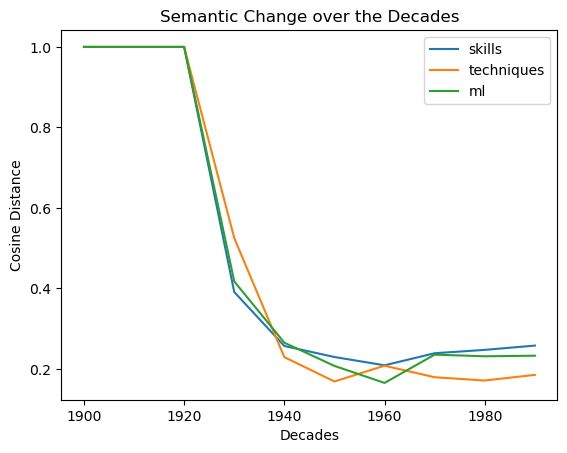

In [305]:
plt.plot(data['d'], d['skills'])
plt.plot(data['d'], d['techniques'])
plt.plot(data['d'], d['ml'])
plt.legend(change_words)
plt.ylabel('Cosine Distance')
plt.xlabel('Decades')
plt.title('Semantic Change over the Decades')
plt.show()

From the graph above, we can observe changes in the cosine distance for each word through the decades. 

For `skills`, we can see a change point around 1940, for `techniques`, we can see a change point around 1950, and for `ml`, we see a change point around 1960. We can tell these are the change points because this is where you can see that there is a shift in the mean of the score and a drastic decrease. Hence, by that point, the word has shifted its meaning and we begin to see that the distance  